In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

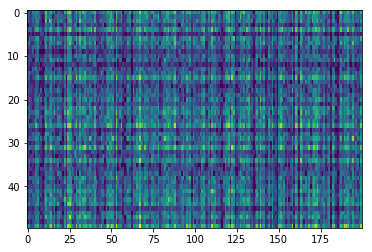

In [2]:
m, n, rank = 50, 200, 3

W_true = npr.rand(m, rank)
H_true = npr.rand(rank, n)

data = np.dot(W_true, H_true)
data += npr.randn(m, n) * .2
data = np.maximum(0, data)

plt.imshow(data, aspect='auto', interpolation='none')

In [3]:
from lvl.factor_models import NMF
model = NMF(n_components=1)
model.fit(data)

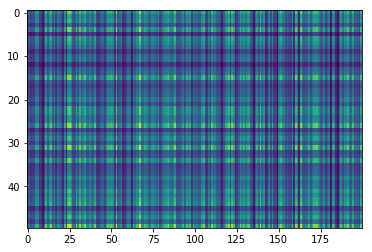

In [4]:
W, H = model.factors
est = np.dot(W, H)
plt.imshow(est, aspect='auto', interpolation='none')

In [5]:
from tqdm import tqdm
from lvl.crossval import cv_scores

n_ranks = 5
ranks = np.arange(1, n_ranks + 1)
n_repeats = 40

nmf_train_scores = np.ones((n_ranks, n_repeats))
nmf_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = NMF(n_components=rank)
    nmf_train_scores[i], nmf_test_scores[i] = \
        cv_scores(model, data, n_repeats=n_repeats)

100%|██████████| 5/5 [00:04<00:00,  1.10s/it]


In [6]:
from lvl.factor_models import TSVD

tsvd_train_scores = np.ones((n_ranks, n_repeats))
tsvd_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = TSVD(n_components=rank)
    tsvd_train_scores[i], tsvd_test_scores[i] = \
        cv_scores(model, data, n_repeats=n_repeats)    

100%|██████████| 5/5 [00:04<00:00,  1.01s/it]


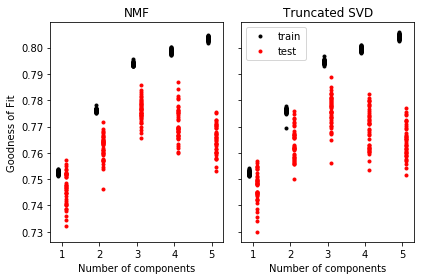

In [8]:
fig, axes = plt.subplots(1, 2, sharey=True)

rax = np.tile(ranks, (n_repeats, 1)).T.ravel()

axes[0].plot(rax-.1, nmf_train_scores.ravel(), '.k');
axes[0].plot(rax+.1, nmf_test_scores.ravel(), '.r');
axes[0].set_title("NMF")

axes[1].plot(rax-.1, tsvd_train_scores.ravel(), '.k', label='train');
axes[1].plot(rax+.1, tsvd_test_scores.ravel(), '.r', label='test');
axes[1].set_title("Truncated SVD")
axes[1].legend()

axes[0].set_ylabel("Goodness of Fit")
for ax in axes:
    ax.set_xlabel("Number of components")
plt.tight_layout()